## *사용상 부주의로 인한 책임은 사용자에게 있습니다*
# kw_condition
 - [키움증권 조건검색 유튜브 가이드](https://www.youtube.com/watch?v=THCpQya4bXE&t=189s&ab_channel=%EC%B0%BD%EC%9B%90%EA%B0%9C%EB%AF%B8TV)

## 개발 환경  
 - Python 3.9.13 32bit
 - PySide2 5.15 >=
 - [키움증권 Open API+](https://www1.kiwoom.com/nkw.templateFrameSet.do?m=m1408000000)  
 - 파이썬 패키지 관리툴 poetry 로 패키지 자동 설치 ([가이드](https://blog.gyus.me/2020/introduce-poetry/))
 

 ## 개발 문서  
 - [키움 오픈 API pdf 매뉴얼](https://download.kiwoom.com/web/openapi/kiwoom_openapi_plus_devguide_ver_1.5.pdf)

## 참고 소스 
 - from https://github.com/sculove/QWebview-plus
 - from https://github.com/elbakramer/koapy


## 개발 환경 설정 
~~~~
# poetry 설치 (using pipx)
> python -m pip install pipx
> python -m pipx ensurepath
> pipx install poetry

# poetry virtualenv 환경, 프로젝트 내부 경로로 설정 
> poetry config virtualenvs.in-project true
> poetry config virtualenvs.path "./.venv"

# poetry 32bit python 사용토록 설정
> poetry env use /path/to/32bit_python/python.exe

# 종속 패키지 설치 
> poetry install
~~~~

## 사용 방법


 ### 0. python 실행 경로 확인 
    - python 가상 환경을 사용 중이라면 가상 환경의 path 가 맞는지 확인한다. 


In [1]:
%gui qt5
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

import sys
print(sys.executable)

d:\1git\kw_condition\.venv\Scripts\python.exe


### 1. 객체 생성

In [2]:
from kw_condition import KiwoomOpenApiPlus
from kw_condition.utils import common_util

from PySide2.QtWidgets import QApplication

myApp = None
if isinstance(QApplication.instance(), type(None)):
    print('make instance')
    myApp = QApplication([])
else:
    print("use already")
    myApp = QApplication.instance()

kw_obj = KiwoomOpenApiPlus()

make instance


### 2. 서버접속
* 자동로그인이 설정되어 있는 경우 로그인이 자동으로 처리 되며, 그렇지 않은 경우 팝업 창에서 수동으로 아이디, 비밀번호 정보를 입력해야함 
- TODO
    * 자동 로그인 설정되지 않은 상태서 로그인 정보를 외부에서 입력한 경우 매크로로 자동처리 할수 있도록 해야함 pywinauto

In [3]:
kw_obj.tryConnect()
common_util.process_qt_events(kw_obj.isConnected, 60)

* 13:44:30.531945 tryConnect 
* 13:44:48.684713 _OnEventConnect 0
* 13:44:48.693719 connected_entered 
account count: 1, keyboard_boan: 1, firewall: 2


### 3. 서버 접속 상태 확인 

In [4]:
kw_obj.isConnected()

True

### 4. 코드 번호를 통해 종목 이름 확인 

In [5]:
name = "삼성전자"
code = kw_obj.code_by_names[name]
code 

'005930'

### 5. TR (주식기본정보요청) - Single Data

아래 처럼 직접 TR 요청에 필요한 입력값을 설정해 요청하고, 이후 들어오는 이벤트 또한 직접 처리해주는 방식으로 사용할 수 있다.

In [6]:
rqname = '주식기본정보요청'
trcode = 'opt10001'
screen_no = '0001'  # 화면번호, 0000 과 9000 이상을 제외한 4자리 숫자 임의로 지정, screen_no 생략한 경우 임의로 화면 번호 지정 

inputs = {'종목코드': '005930'}

kw_obj.add_transaction(rqname, trcode, inputs, screen_no)

common_util.process_qt_events(kw_obj.has_transaction_result(rqname), 5)

# TR result 를 get 해야 다시 동일 rqname 으로 재요청 가능함 
kw_obj.get_transaction_result(rqname) 


* 13:44:48.990976 _OnReceiveTrData  sScrNo: 9199, rQName: 주식기본정보요청, trCode: opt10001, recordName: , prevNext 0


['005930', '+77600', '-41800', '59700']

### 6. TR(주식일봉차트조회요청) - Multi Data  

In [7]:
import datetime

rqname = '주식일봉차트조회요청'
trcode = 'opt10081'

current_time_str = datetime.datetime.now().strftime('%Y%m%d')

inputs = {'종목코드': '005930', '기준일자' : current_time_str, "수정주가구분": '1'}

kw_obj.add_transaction(rqname, trcode, inputs)

common_util.process_qt_events(kw_obj.has_transaction_result(rqname), 5)

# result 를 get 해야 다시 동일 rqname 으로 재요청 가능함 

daily_list = kw_obj.get_transaction_result(rqname)
print( len(daily_list) )
daily_list[-5: ] 

* 13:44:49.231150 _OnReceiveTrData  sScrNo: 9198, rQName: 주식일봉차트조회요청, trCode: opt10081, recordName: , prevNext 2
600


[['', '20200331', '48000', '48500', '47150', '47750', '30654261'],
 ['', '20200330', '47050', '48350', '46550', '47850', '26797395'],
 ['', '20200327', '49600', '49700', '46850', '48300', '39896178'],
 ['', '20200326', '49000', '49300', '47700', '47800', '42185129'],
 ['', '20200325', '48950', '49600', '47150', '48650', '52735922']]

### 6. TR(주식일봉차트조회요청) - Multi Data - 연속 조회 

In [8]:
import datetime

rqname = '주식일봉차트조회요청'
trcode = 'opt10081'

current_time_str = datetime.datetime.now().strftime('%Y%m%d')

inputs = {'종목코드': '005930', '기준일자' : current_time_str, "수정주가구분": '1'}

# 연속 조회시 prev_next 값을 2로 입력한다.  
kw_obj.add_transaction(rqname, trcode, inputs, prev_next=2 )

common_util.process_qt_events(kw_obj.has_transaction_result(rqname), 5)

# result 를 get 해야 다시 동일 rqname 으로 재요청 가능함 
daily_list.extend( kw_obj.get_transaction_result(rqname) ) 
print( len(daily_list) )
daily_list[ -5:]





* 13:44:49.480229 _OnReceiveTrData  sScrNo: 9197, rQName: 주식일봉차트조회요청, trCode: opt10081, recordName: , prevNext 2
1200


[['', '20171020', '52800', '54100', '52800', '53840', '8027050'],
 ['', '20171019', '54700', '54700', '52980', '52980', '12108700'],
 ['', '20171018', '54820', '55240', '54040', '54760', '10110750'],
 ['', '20171017', '54020', '55380', '54000', '54800', '10607800'],
 ['', '20171016', '53980', '54860', '53760', '53920', '9769950']]

### 6. TR(주식일봉차트조회요청) - Multi Data - 차트 출력  

             Open   High    Low  Close    Volume
Date                                            
2017-10-16  53980  54860  53760  53920   9769950
2017-10-17  54020  55380  54000  54800  10607800
2017-10-18  54820  55240  54040  54760  10110750
2017-10-19  54700  54700  52980  52980  12108700
2017-10-20  52800  54100  52800  53840   8027050


d:\1git\kw_condition\.venv\lib\site-packages\mplfinance\_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


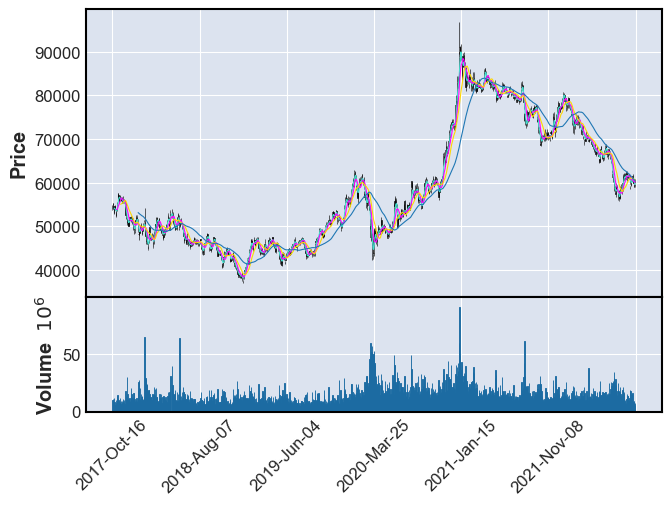

In [9]:
import mplfinance as mpf

daily_df = pd.DataFrame( daily_list, columns=["StockCode", "Date", "Open", "High", "Low", "Close", "Volume"] ) 

# 일봉 조회의 경우 종목 코드가 2번째 row 부터 공백이므로 삭제 
daily_df.drop(columns='StockCode', axis =1, inplace = True)

# string date -> datetime 
daily_df['Date'] = pd.to_datetime( daily_df['Date'], format = '%Y%m%d') 

# str to int
selected_cols = ["Open", "High", "Low", "Close", "Volume"]
daily_df[ selected_cols ] = daily_df[selected_cols].astype('int')

daily_df = daily_df.set_index('Date')

daily_df = daily_df.sort_values(by= 'Date')

print(daily_df.head(5))

# 5, 10 , 20 , 60 일 평균 선 추가 
mpf.plot(daily_df, type='candle', mav=(5, 10, 20, 60), volume= True)



### 7. 전종목 일봉 Excel 출력
전체 종목의 일봉 데이터를 Excel 로 만든다 

주의사항: 과도한 조회는 오류 팝업 발생 후 재접속 해야 하므로 주의!

In [10]:
import datetime
import pandas as pd
import time

current_time_str = datetime.datetime.now().strftime('%Y%m%d')

for code in kw_obj.code_by_names.values():
    trcode = 'opt10081'
    stock_name = kw_obj.getMasterCodeName( code )
    rqname = '{}: 주식일봉차트조회요청'.format( stock_name ) 

    inputs = {'종목코드': '{}'.format( code ), '기준일자' : current_time_str, "수정주가구분": '1'}

    daily_list = []
    prev_next = 0

    while False:
        kw_obj.add_transaction(rqname, trcode, inputs, prev_next = prev_next)
        common_util.process_qt_events(kw_obj.has_transaction_result(rqname), 5)
        
        has_additional_data = kw_obj.has_transaction_additional_data(rqname)

        # result 를 get 해야 다시 동일 rqname 으로 재요청 가능함 
        daily_list.extend( kw_obj.get_transaction_result(rqname) )

        if( has_additional_data == True ):
            prev_next = 2
        else:

            daily_df = pd.DataFrame( daily_list, columns=["StockCode", "Date", "Open", "High", "Low", "Close", "Volume"] )     

            # 일봉 조회의 경우 종목 코드가 2번째 row 부터 공백이므로 삭제 
            daily_df.drop(columns='StockCode', axis =1, inplace = True)

            # string date -> datetime 
            daily_df['Date'] = pd.to_datetime( daily_df['Date'], format = '%Y%m%d') 

            # str to int
            selected_cols = ["Open", "High", "Low", "Close", "Volume"]
            daily_df[ selected_cols ] = daily_df[selected_cols].astype('int')

            daily_df = daily_df.set_index('Date')

            daily_df = daily_df.sort_values(by= 'Date')

            print(daily_df.head(2))

            # Excel 생성 
            daily_df.to_excel('{}({}).xlsx'.format( stock_name, code ) )
            time.sleep(10)

            break

### 8. 조건 검색 (사용자 설정 조건 리스트 읽기 from HTS)
이후 예시의 정상동작을 위해서는 아래에서 사용되는 조건들과 같은 이름을 가지는 조건들이 미리 저장되어 있어야 한다.

참고로 조건들을 편집하고 저장하는건 영웅문 HTS 내부에서만 가능하기 때문에 따로 HTS 를 열어 편집해주어야 한다.

In [11]:
kw_obj.load_condition_names()
common_util.process_qt_events(kw_obj.has_condition_names, 5)
print( kw_obj.get_condition_names() )


* 13:44:51.673914 _OnReceiveConditionVer  ret: 1, msg: [OK] 사용자 조건검색식 읽기
{'장초반': 1, '휴식': 2, '장후반': 0, '이탈3': 4, '이탈15': 6, '새조건명': 3, '새조건명2': 5}


### 8. 조건검색 (사용자 조건과 일치하는 종목 리턴)

In [12]:
condition_name = '장초반'
kw_obj.request_condition(condition_name)

def func() -> bool:
    return False
common_util.process_qt_events(func, 5)



* 13:44:51.767751 _OnReceiveTrCondition  scrNo: 9196, codeList: 012450;048410;053690;054930;, conditionName: 장초반 index: 1, next: 0
condition list add: 012450 한화에어로스페이스
condition list add: 048410 현대바이오
condition list add: 053690 한미글로벌
condition list add: 054930 유신
time out!


### 9. 실시간 조건 검색 

### 10. 주문 처리